In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Dense, Reshape, Flatten, Softmax, Lambda, SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from scipy.special import kl_div

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load dataset

#### Custom Dataloader

In [2]:
def load_image(path, size, mask=False):
    image = Image.open(path)
    image = image.resize((size, size))

    if mask:
        image = image.convert('L')  # Convert to grayscale
    else:
        image = image.convert('RGB')  # Convert to RGB
    
    image = np.array(image)
    return image

def load_data(root_path, size):
    images = []
    masks = []

    image_folder = os.path.join(root_path, 'original')
    mask_folder = os.path.join(root_path, 'GT')

    for image_path in sorted(glob(os.path.join(image_folder, '*png'))):
        img_id = os.path.basename(image_path).split('.')[0]
        mask_path = os.path.join(mask_folder, f'{img_id}.png')

        img = load_image(image_path, size) / 255.0
        mask = load_image(mask_path, size, mask=True) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [3]:
size = 512   # image size: 128x128
root_path = '/kaggle/input/udiat-segmentation-dataset/UDIAT_Dataset_B/'
X, y = load_data(root_path, size)

In [4]:
# drop normal class because normal class has not mask
# X = X[:647]
# y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
# X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (163, 512, 512, 3)     |  y shape: (163, 512, 512)

X shape: (163, 512, 512, 3)  |  y shape: (163, 512, 512, 1)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_val shape:',X_val.shape)
print('y_val shape:',y_val.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (116, 512, 512, 3)
y_train shape: (116, 512, 512, 1)
X_val shape: (30, 512, 512, 3)
y_val shape: (30, 512, 512, 1)
X_test shape: (17, 512, 512, 3)
y_test shape: (17, 512, 512, 1)


#### Visualization of training images

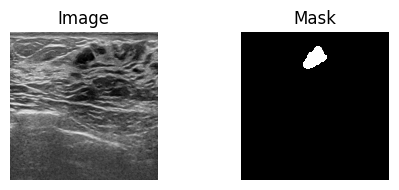

In [6]:
image = X_train[31]
mask = y_train[31]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

#### Visualization of validation images

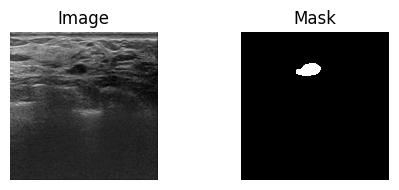

In [7]:
image = X_test[4]
mask = y_test[4]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

#### Visualization of testing images

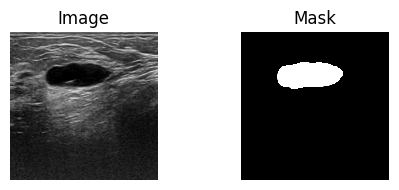

In [8]:
image = X_test[5]
mask = y_test[5]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

## Custom metrics and losses

#### Metrics

In [9]:
def dice_score(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return score

def iou(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    union = K.sum(y_true_flat) + K.sum(y_pred_flat) - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

def recall(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fn = K.sum(y_true_flat * (1 - y_pred_flat))
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall

def precision(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fp = K.sum((1 - y_true_flat) * y_pred_flat)
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision

#### Loss

In [10]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_score(y_true, y_pred)
    return loss

def iou_loss(y_true, y_pred):
    loss = 1 - iou(y_true, y_pred)
    return loss
    
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = tf.reduce_mean(-focal_weight * tf.math.log(pt))
    return loss

def bce_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return loss

def combined_loss(y_true, y_pred):
    loss = dice_loss(y_true, y_pred) + bce_loss(y_true, y_pred)
    return loss

# Custom UNet architecture

#### Wavelet

In [11]:
def wavelet(feature_map):
    B,H,W,C = feature_map.shape
    wav = tf.image.sobel_edges(feature_map)
    wav1 = wav[:,:,:,0]
    wav2 = wav[:,:,:,1]
    wav = tf.keras.layers.Concatenate()([wav1,wav2])
    wav = tf.keras.layers.Conv2D(2*C, (3,3), (1,1),padding="same")(wav) 
    wav = tf.keras.layers.Conv2D(C, (1,1), (1,1),padding="same")(wav) 
    return wav 

#### SE Block

In [12]:
def SE(x):
    x = Conv2D(32, 3, padding="same")(x)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
    x1 = tf.keras.layers.Dense(8, activation='relu')(x1)
    x1 = tf.keras.layers.Dense(32, activation='sigmoid')(x1)
    x1 = tf.keras.layers.Reshape((1, 1, 32))(x1)
    x = tf.keras.layers.Multiply()([x, x1])
    return x

#### Similarity-aware Attention

In [13]:
def FSiAM(x):
    x1 = tf.keras.layers.Permute((2, 1))(x)
    x2 = tf.matmul(x1, x)
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    x2 = tf.keras.activations.sigmoid(x2)
    x2 = tf.expand_dims(x2, axis=1)
    x2 = tf.expand_dims(x2, axis=1)
    return x2

#### Ensemble Layer

In [14]:
class EnsembleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EnsembleLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(EnsembleLayer, self).build(input_shape)
        # trainable weight
        self.weights_variable = tf.Variable(
            initial_value=tf.ones((6,), dtype=tf.float32),
            trainable=True,
            name='weights'
        )

    def call(self, inputs):
        y1, y2, y3, y4, y5, y6 = inputs
        stacked_masks = tf.stack([y1, y2, y3, y4, y5, y6], axis=-1)
        normalized_weights = tf.nn.softmax(self.weights_variable) # normalize weights between 0 and 1
        final_mask = tf.reduce_sum(stacked_masks * tf.expand_dims(normalized_weights, axis=0), axis=-1)
        #final_mask = tf.where(final_mask > 0.5, 1.0, 0.0)
        return final_mask

    def compute_output_shape(self, input_shape):
        # The output shape is the same as the input shape of the masks (height, width, num_classes)
        return input_shape[0][:-1] + (1,)

    def get_config(self):
        config = super().get_config()
        return config

#### Custom U2NeT architecture

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Add

def conv_block(inputs, out_ch, rate=1):
    x = SeparableConv2D(out_ch, 3, padding="same", dilation_rate=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
    """ Initial Conv """
    x = conv_block(inputs, out_ch)
    init_feats = x

    """ Encoder """
    skip = []
    x = conv_block(x, int_ch)
    skip.append(x)

    for i in range(num_layers-2):
        x = MaxPool2D((2, 2))(x)
        x = conv_block(x, int_ch)
        skip.append(x)

    """ Bridge """
    x = conv_block(x, int_ch, rate=rate)

    """ Decoder """
    skip.reverse()

    x = Concatenate()([x, skip[0]])
    x = conv_block(x, int_ch)

    for i in range(num_layers-3):
        x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = Concatenate()([x, skip[i+1]])
        x = conv_block(x, int_ch)

    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Concatenate()([x, skip[-1]])
    x = conv_block(x, out_ch)

    """ Add """
    x = Add()([x, init_feats])
    return x

def RSU_4F(inputs, out_ch, int_ch):
    """ Initial Conv """
    x0 = conv_block(inputs, out_ch, rate=1)

    """ Encoder """
    x1 = conv_block(x0, int_ch, rate=1)
    x2 = conv_block(x1, int_ch, rate=2)
    x3 = conv_block(x2, int_ch, rate=4)

    """ Bridge """
    x4 = conv_block(x3, int_ch, rate=8)

    """ Decoder """
    x = Concatenate()([x4, x3])
    x = conv_block(x, int_ch, rate=4)

    x = Concatenate()([x, x2])
    x = conv_block(x, int_ch, rate=2)

    x = Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    """ Addition """
    x = Add()([x, x0])
    return x

def u2net(input_shape, out_ch, int_ch, num_classes=1):
    """ Input Layer """
    inputs = Input(input_shape)
    s0 = inputs

    """ Encoder """
    s1 = RSU_L(s0, out_ch[0], int_ch[0], 7)
    p1 = MaxPool2D((2, 2))(s1)

    s2 = RSU_L(p1, out_ch[1], int_ch[1], 6)
    p2 = MaxPool2D((2, 2))(s2)

    s3 = RSU_L(p2, out_ch[2], int_ch[2], 5)
    p3 = MaxPool2D((2, 2))(s3)

    s4 = RSU_L(p3, out_ch[3], int_ch[3], 4)
    p4 = MaxPool2D((2, 2))(s4)

    s5 = RSU_4F(p4, out_ch[4], int_ch[4])
    p5 = MaxPool2D((2, 2))(s5)

    """ Bridge """
    b1 = RSU_4F(p5, out_ch[5], int_ch[5])
    b2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    """ Decoder """
    x = FSiAM(tf.keras.layers.Reshape((s5.shape[1]*s5.shape[2],s5.shape[3]))(s5))
    x = tf.keras.layers.Multiply()([s5, x])
    fft = wavelet(s5) 
    d1 = Concatenate(name="ONE")([SE(b2), x, fft])
    d1 = tf.keras.layers.SeparableConv2D(512,(3,3),(1, 1),padding="same")(d1)
    d1 = tf.keras.layers.SeparableConv2D(256,(1,1),(1, 1),padding="same")(d1)
    d1 = RSU_4F(d1, out_ch[6], int_ch[6])
    u1 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)
    
    x = FSiAM(tf.keras.layers.Reshape((s4.shape[1]*s4.shape[2],s4.shape[3]))(s4))
    x = tf.keras.layers.Multiply()([s4, x])
    fft = wavelet(s4)
    d2 = Concatenate(name="TWO")([SE(u1), x, fft])
    d2 = tf.keras.layers.SeparableConv2D(256,(3,3),(1, 1),padding="same")(d2)
    d2 = tf.keras.layers.SeparableConv2D(128,(1,1),(1, 1),padding="same")(d2)
    d2 = RSU_L(d2, out_ch[7], int_ch[7], 4)
    u2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)
    
    x = FSiAM(tf.keras.layers.Reshape((s3.shape[1]*s3.shape[2],s3.shape[3]))(s3))
    x = tf.keras.layers.Multiply()([s3, x])
    fft = wavelet(s3)
    d3 = Concatenate(name="THREE")([SE(u2), x, fft])
    d3 = tf.keras.layers.SeparableConv2D(128,(3,3),(1, 1),padding="same")(d3)
    d3 = tf.keras.layers.SeparableConv2D(64,(1,1),(1, 1),padding="same")(d3)
    d3 = RSU_L(d3, out_ch[8], int_ch[8], 5)
    u3 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    x = FSiAM(tf.keras.layers.Reshape((s2.shape[1]*s2.shape[2],s2.shape[3]))(s2))
    x = tf.keras.layers.Multiply()([s2, x])
    fft = wavelet(s2)
    d4 = Concatenate(name="FOUR")([SE(u3), x, fft])
    d4 = tf.keras.layers.SeparableConv2D(64,(3,3),(1, 1),padding="same")(d4)
    d4 = tf.keras.layers.SeparableConv2D(32,(1,1),(1, 1),padding="same")(d4)
    d4 = RSU_L(d4, out_ch[9], int_ch[9], 6)
    u4 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)
    
    x = FSiAM(tf.keras.layers.Reshape((s1.shape[1]*s1.shape[2],s1.shape[3]))(s1))
    x = tf.keras.layers.Multiply()([s1, x])
    fft = wavelet(s1)
    d5 = Concatenate(name="FIVE")([SE(u4), x, fft])
    d5 = tf.keras.layers.SeparableConv2D(32,(3,3),(1, 1),padding="same")(d5)
    d5 = tf.keras.layers.SeparableConv2D(16,(1,1),(1, 1),padding="same")(d5)
    d5 = RSU_L(d5, out_ch[10], int_ch[10], 7)

    """ Side Outputs """
    y1 = Conv2D(num_classes, 3, padding="same")(d5)

    y2 = Conv2D(num_classes, 3, padding="same")(d4)
    y2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = Conv2D(num_classes, 3, padding="same")(d3)
    y3 = UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = Conv2D(num_classes, 3, padding="same")(d2)
    y4 = UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = Conv2D(num_classes, 3, padding="same")(d1)
    y5 = UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = Conv2D(num_classes, 3, padding="same")(b1)
    y6 = UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y1 = Activation("sigmoid")(y1)
    y2 = Activation("sigmoid")(y2)
    y3 = Activation("sigmoid")(y3)
    y4 = Activation("sigmoid")(y4)
    y5 = Activation("sigmoid")(y5)
    y6 = Activation("sigmoid")(y6)
    
    y0 = EnsembleLayer(name="ensemble_layer")([y1, y2, y3, y4, y5, y6]) 

    model = tf.keras.models.Model(inputs, outputs=y0)
    return model

def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    int_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

model = build_u2net((512, 512, 3))
optimizer = Adam(lr=0.0001)
model.compile(loss=combined_loss, metrics=["accuracy",dice_score,recall,precision,iou], optimizer = optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 512, 512, 64)         283       ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['separable_conv2d[0][0]']    
 Normalization)                                                                                   
                                                                                              

# Training

In [16]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/seg.hdf5',
    monitor='val_dice_score',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(X_train, y_train,
                    epochs = 50,
                    batch_size = 2,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 1.5378 - accuracy: 0.9422 - dice_score: 0.1833 - recall: 0.1892 - precision: 0.5688 - iou: 0.1080
Epoch 1: val_dice_score improved from -inf to 0.09506, saving model to /kaggle/working/seg.hdf5
58/58 [==============================] - 169s 784ms/step - loss: 1.5378 - accuracy: 0.9422 - dice_score: 0.1833 - recall: 0.1892 - precision: 0.5688 - iou: 0.1080 - val_loss: 1.7305 - val_accuracy: 0.9360 - val_dice_score: 0.0951 - val_recall: 4.8660e-12 - val_precision: 1.0000 - val_iou: 0.0507
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 1.4124 - accuracy: 0.9560 - dice_score: 0.2868 - recall: 0.3797 - precision: 0.4996 - iou: 0.1738
Epoch 2: val_dice_score did not improve from 0.09506
58/58 [==============================] - 42s 721ms/step - loss: 1.4124 - accuracy: 0.9560 - dice_score: 0.2868 - recall: 0.3797 - precision: 0.4996 - iou: 0.1738 - val_loss: 1.6753 - val_accuracy: 0.9360 - val_dice_score: 

#### Plots of metrices and losses

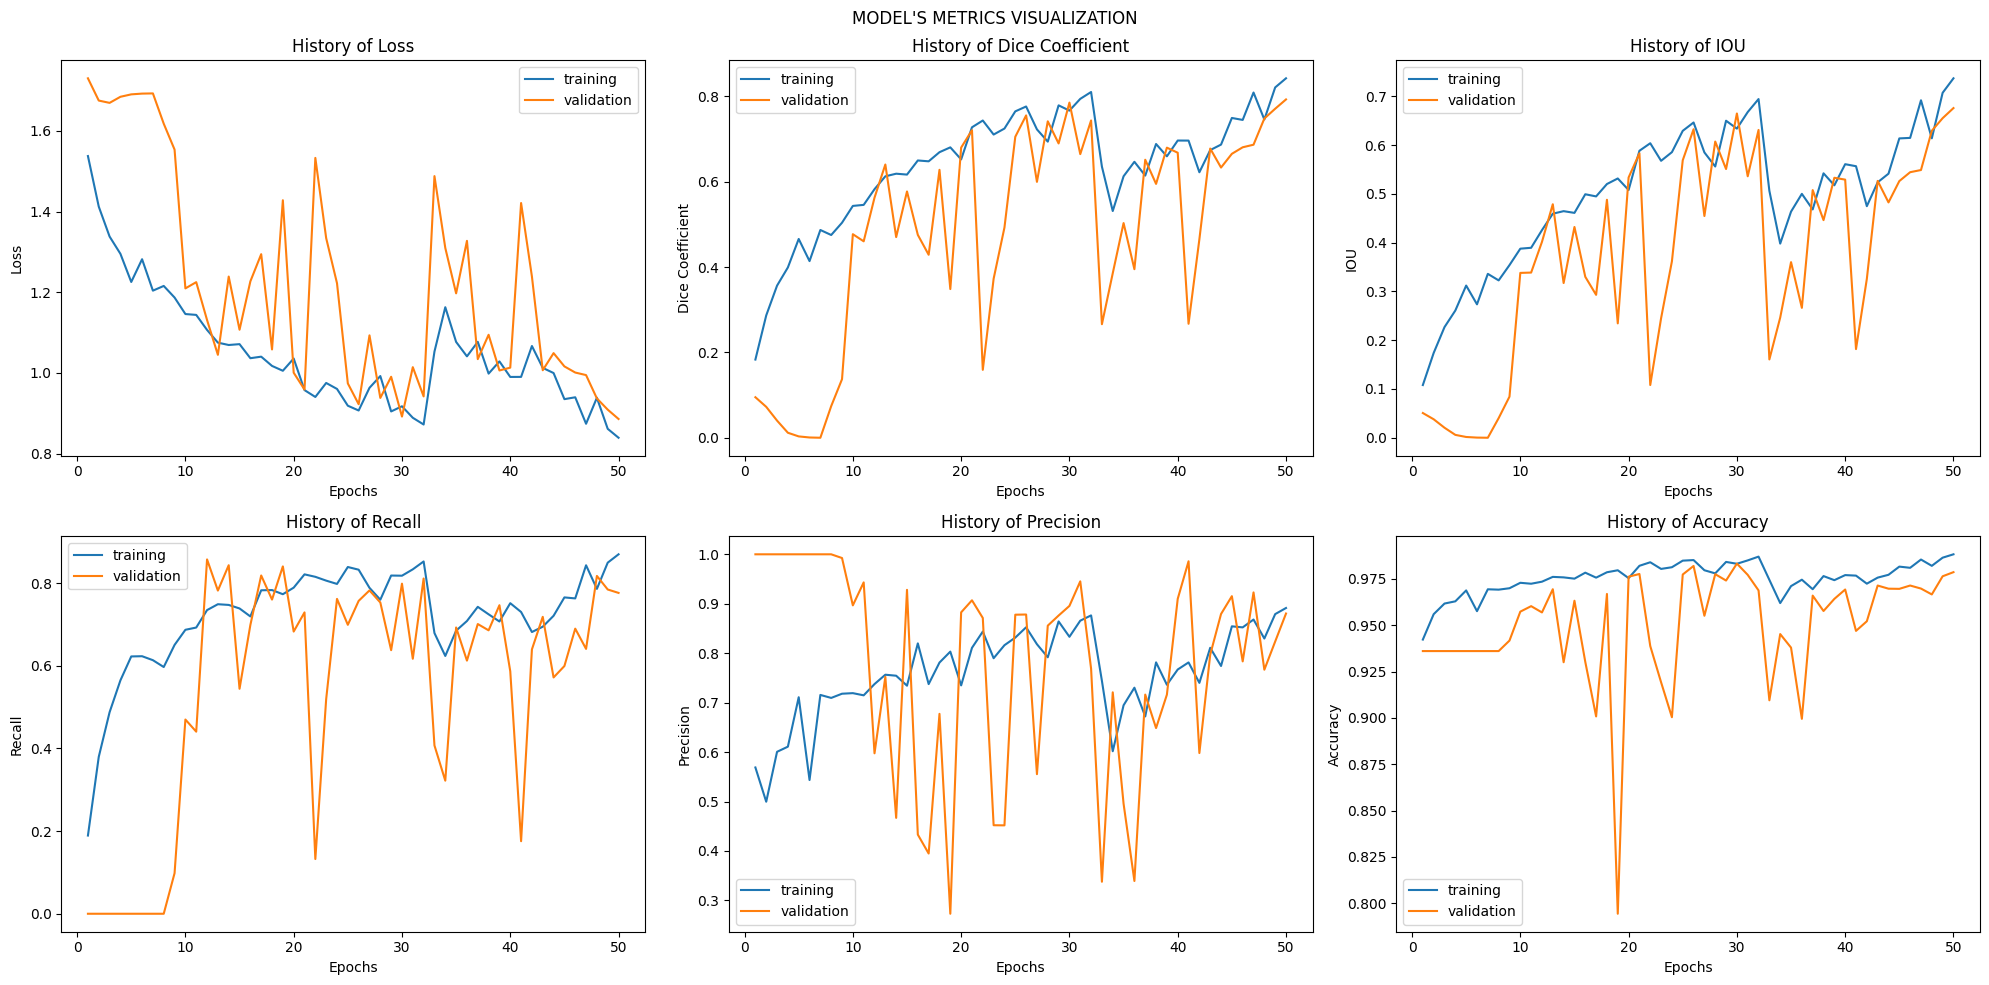

In [17]:
def Train_Val_Plot(loss, val_loss, dice_score, val_dice_score, iou, val_iou, recall, val_recall, precision, val_precision, accuracy, val_accuracy):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    # Loss plot
    axs[0, 0].plot(range(1, len(loss) + 1), loss)
    axs[0, 0].plot(range(1, len(val_loss) + 1), val_loss)
    axs[0, 0].set_title('History of Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(['training', 'validation'])

    # Dice Coefficient plot
    axs[0, 1].plot(range(1, len(dice_score) + 1), dice_score)
    axs[0, 1].plot(range(1, len(val_dice_score) + 1), val_dice_score)
    axs[0, 1].set_title('History of Dice Coefficient')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Dice Coefficient')
    axs[0, 1].legend(['training', 'validation'])

    # Mean IOU plot
    axs[0, 2].plot(range(1, len(iou) + 1), iou)
    axs[0, 2].plot(range(1, len(val_iou) + 1), val_iou)
    axs[0, 2].set_title('History of IOU')
    axs[0, 2].set_xlabel('Epochs')
    axs[0, 2].set_ylabel('IOU')
    axs[0, 2].legend(['training', 'validation'])

    # Recall plot
    axs[1, 0].plot(range(1, len(recall) + 1), recall)
    axs[1, 0].plot(range(1, len(val_recall) + 1), val_recall)
    axs[1, 0].set_title('History of Recall')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['training', 'validation'])

    # Precision plot
    axs[1, 1].plot(range(1, len(precision) + 1), precision)
    axs[1, 1].plot(range(1, len(val_precision) + 1), val_precision)
    axs[1, 1].set_title('History of Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].legend(['training', 'validation'])

    # Accuracy plot
    axs[1, 2].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1, 2].plot(range(1, len(val_accuracy) + 1), val_accuracy)
    axs[1, 2].set_title('History of Accuracy')
    axs[1, 2].set_xlabel('Epochs')
    axs[1, 2].set_ylabel('Accuracy')
    axs[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

Train_Val_Plot(
    history.history['loss'], history.history['val_loss'],
    history.history['dice_score'], history.history['val_dice_score'],
    history.history['iou'], history.history['val_iou'],
    history.history['recall'], history.history['val_recall'],
    history.history['precision'], history.history['val_precision'],
    history.history['accuracy'], history.history['val_accuracy']
)

# Testing

#### Testing results

In [18]:
model.load_weights("/kaggle/working/seg.hdf5")
model.evaluate(X_test, y_test, batch_size=2)

9/9 [==============================] - 9s 550ms/step - loss: 0.8467 - accuracy: 0.9879 - dice_score: 0.8347 - recall: 0.8630 - precision: 0.8928 - iou: 0.7211


[0.8467326164245605,
 0.9878753423690796,
 0.8346955180168152,
 0.8629872798919678,
 0.8928191661834717,
 0.7210668921470642]

#### Segmentation output

##### Decoders

In [19]:
modeller = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer(name="up_sampling2d_33").output,model.get_layer(name="up_sampling2d_34").output,model.get_layer(name="up_sampling2d_35").output,model.get_layer(name="up_sampling2d_36").output,model.get_layer(name="up_sampling2d_37").output])

1/1 [==============================] - 4s 4s/step


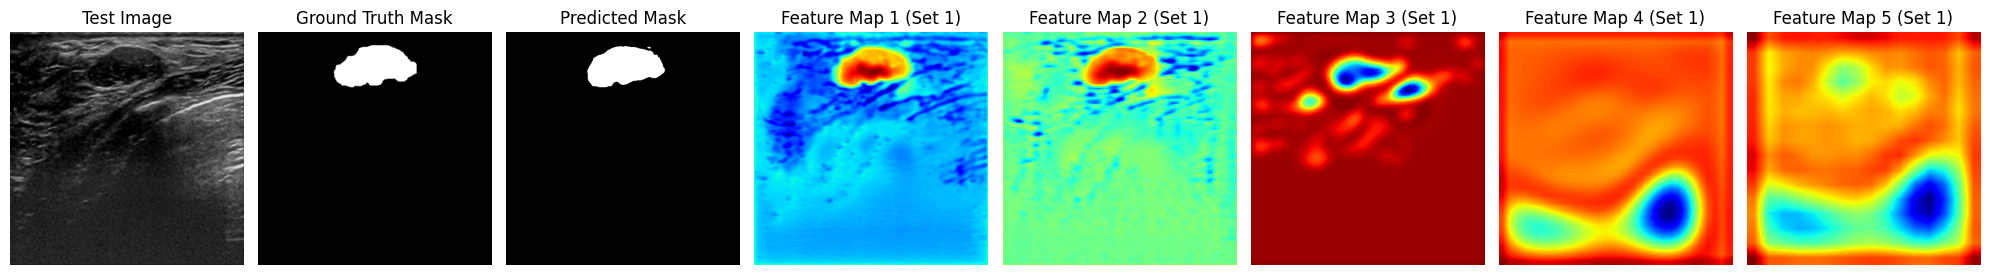

1/1 [==============================] - 0s 35ms/step


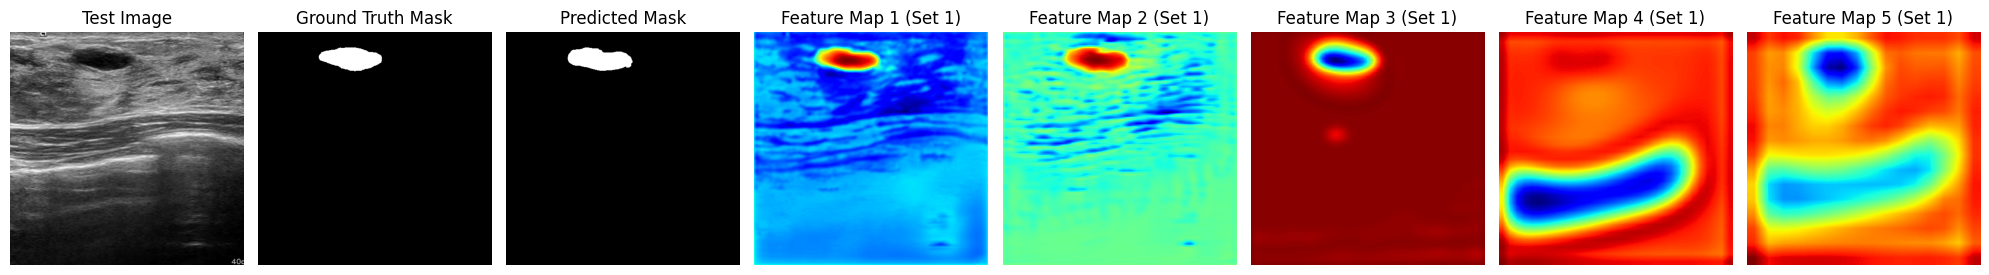

1/1 [==============================] - 0s 33ms/step


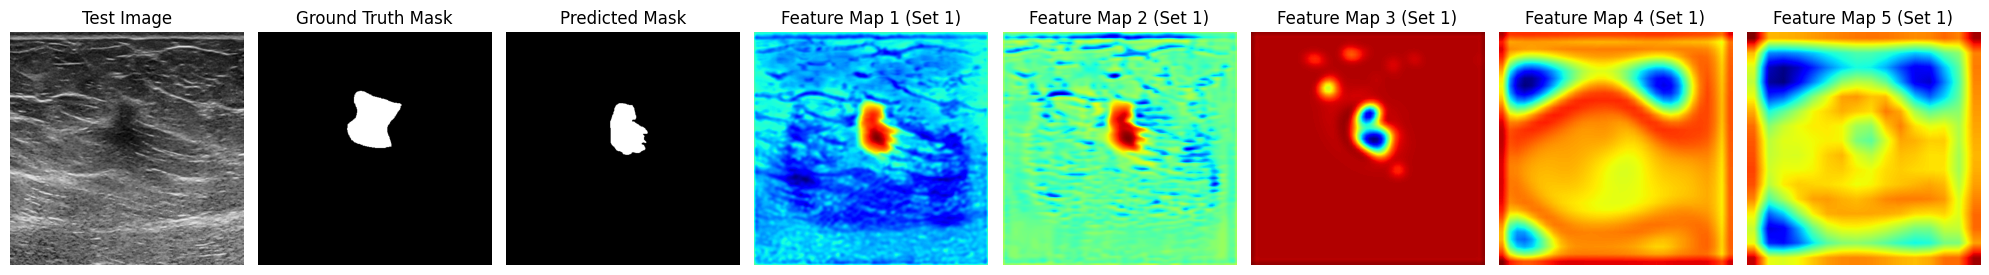

1/1 [==============================] - 0s 32ms/step


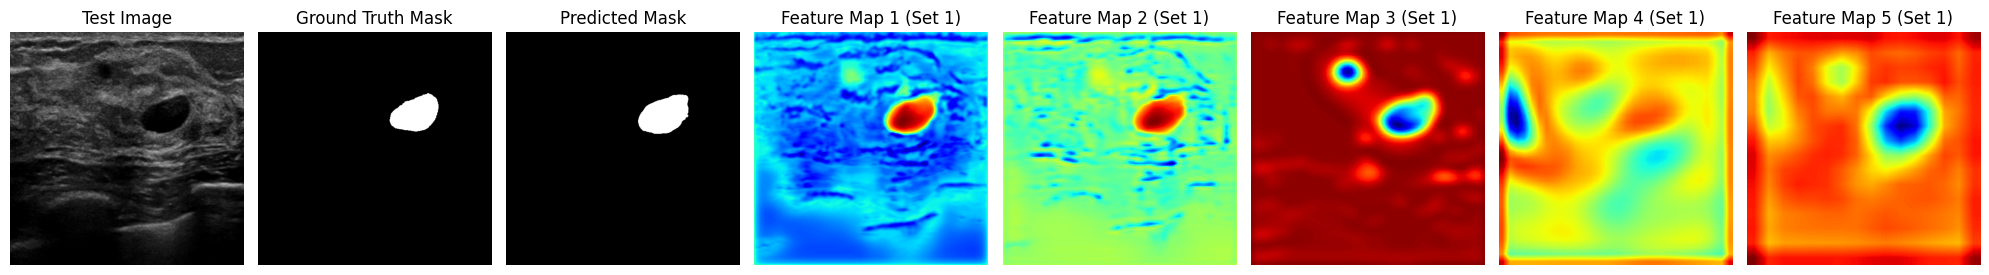

1/1 [==============================] - 0s 32ms/step


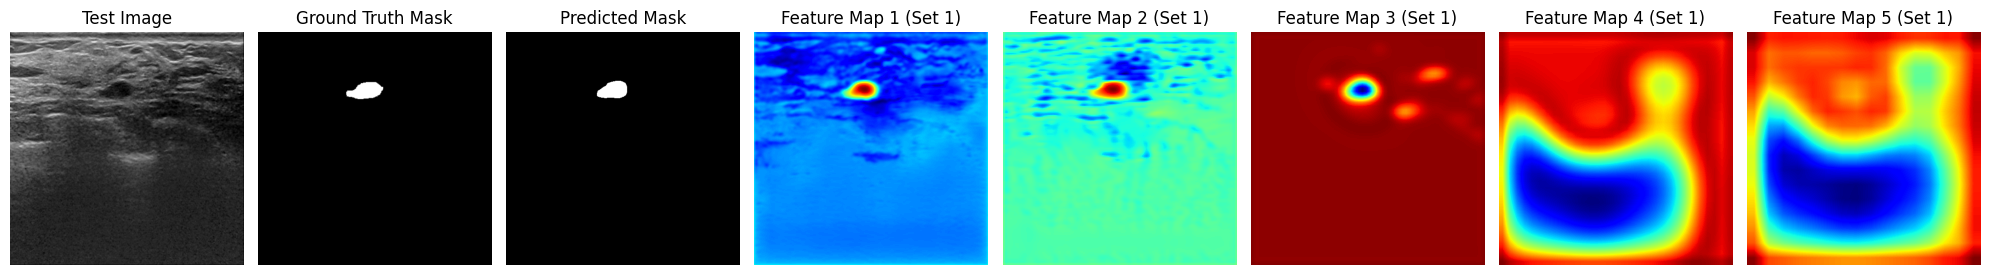

1/1 [==============================] - 0s 32ms/step


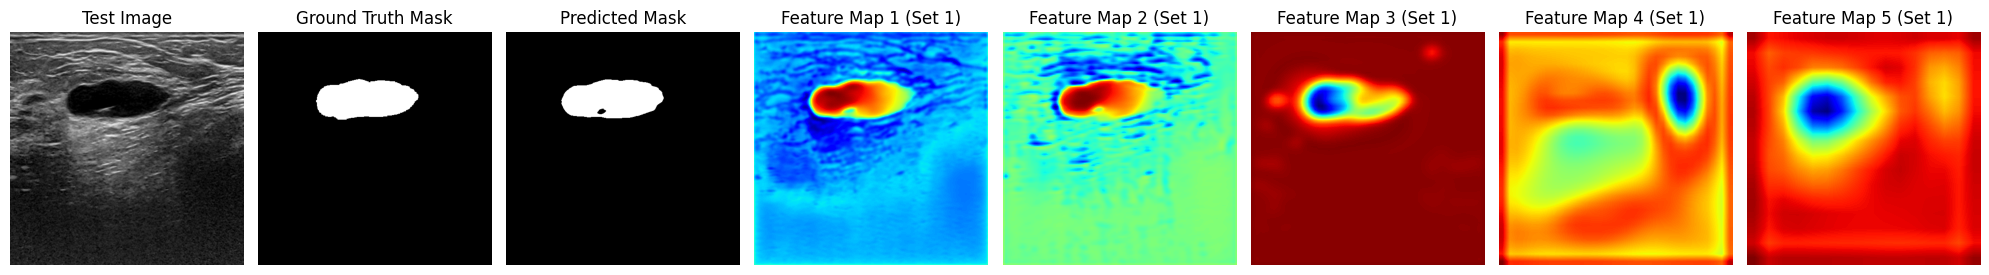

1/1 [==============================] - 0s 32ms/step


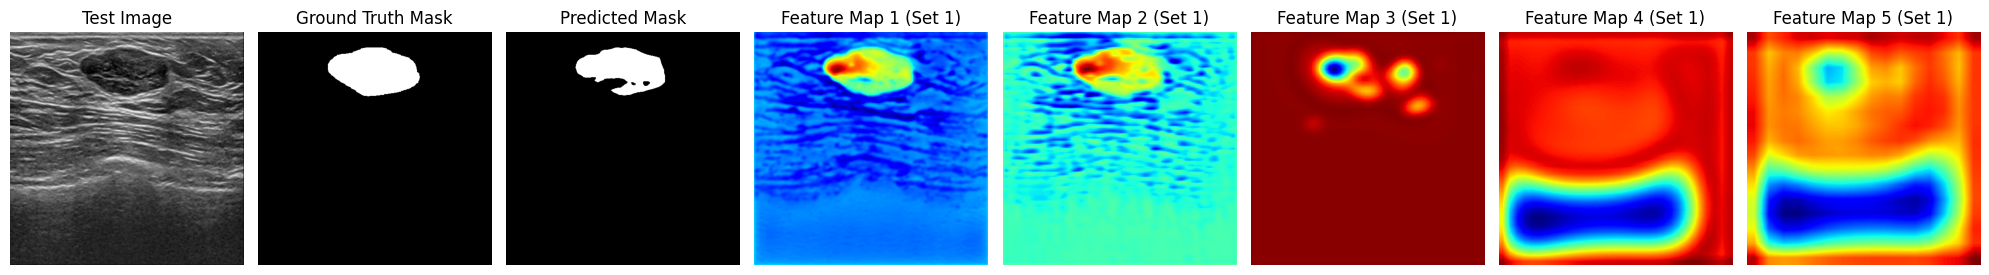

1/1 [==============================] - 0s 33ms/step


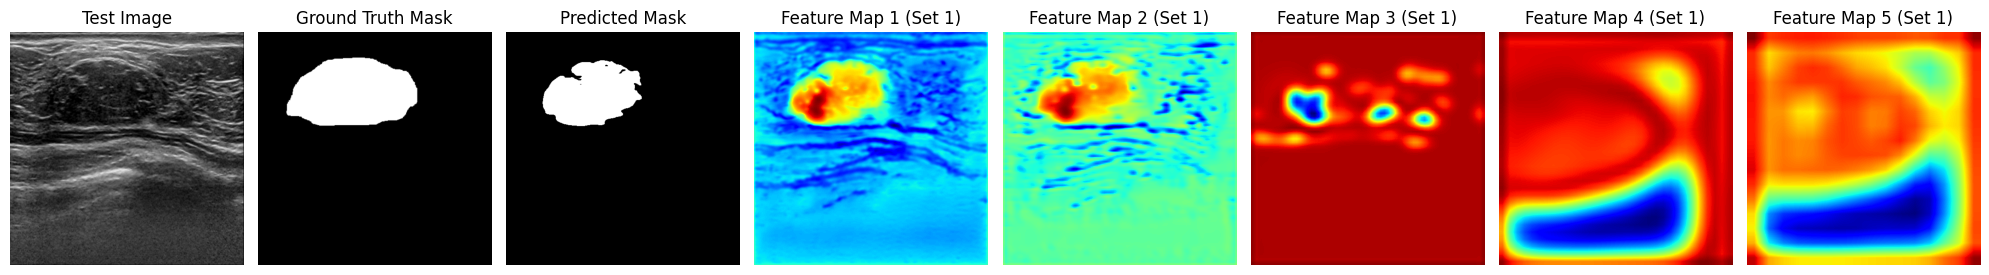

1/1 [==============================] - 0s 33ms/step


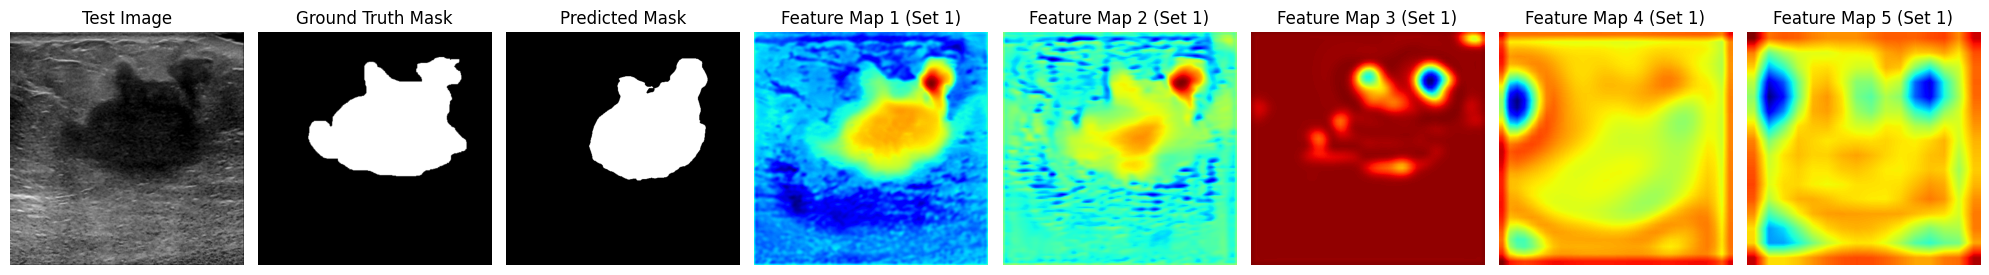

1/1 [==============================] - 0s 32ms/step


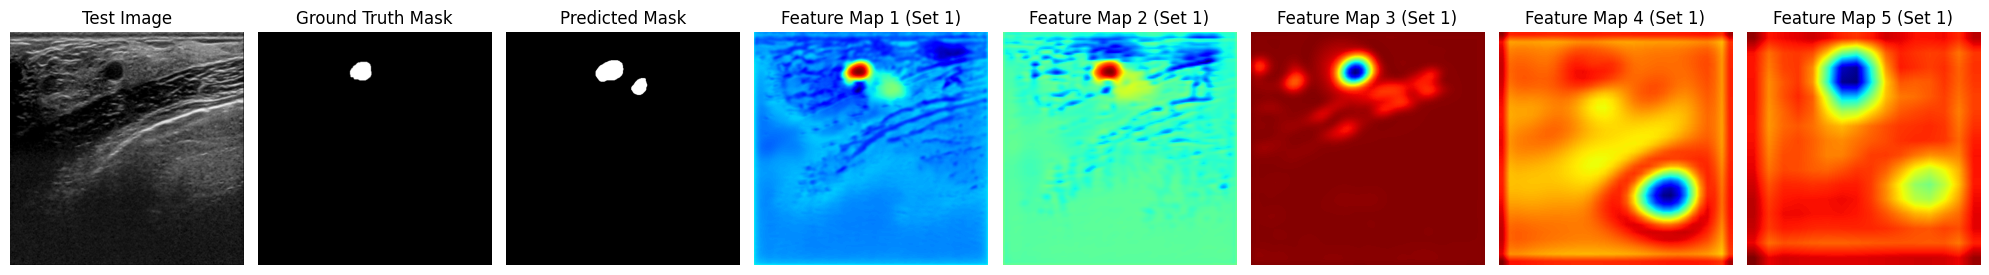

1/1 [==============================] - 0s 32ms/step


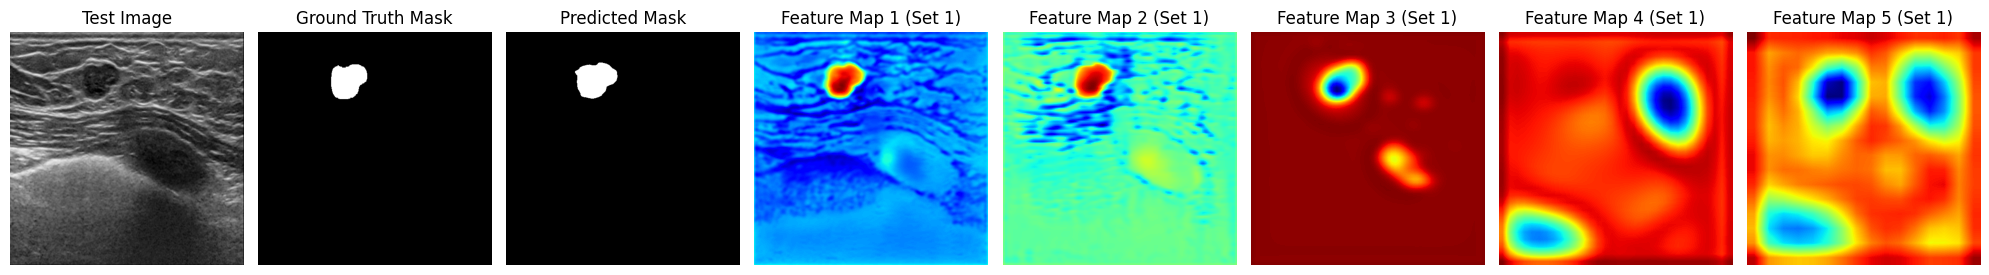

1/1 [==============================] - 0s 32ms/step


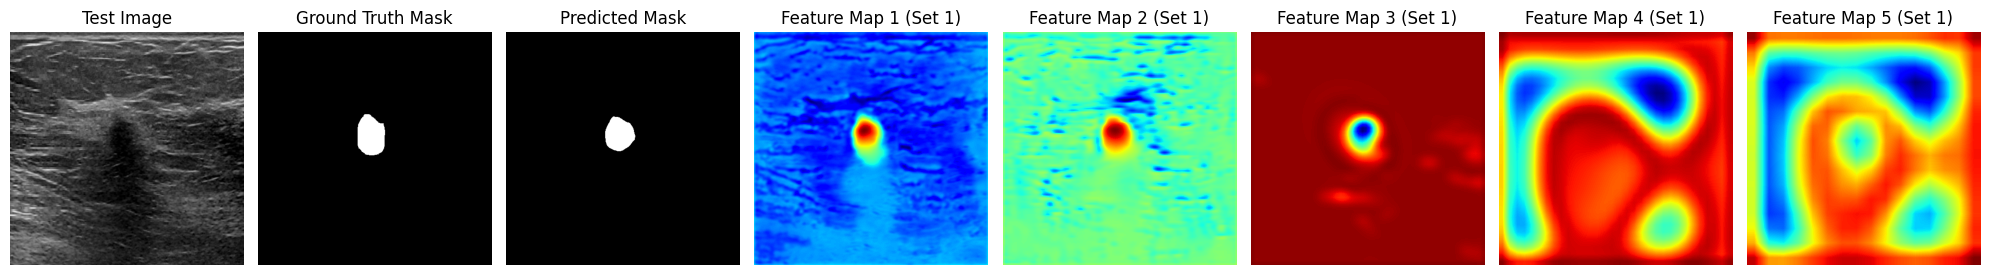

1/1 [==============================] - 0s 31ms/step


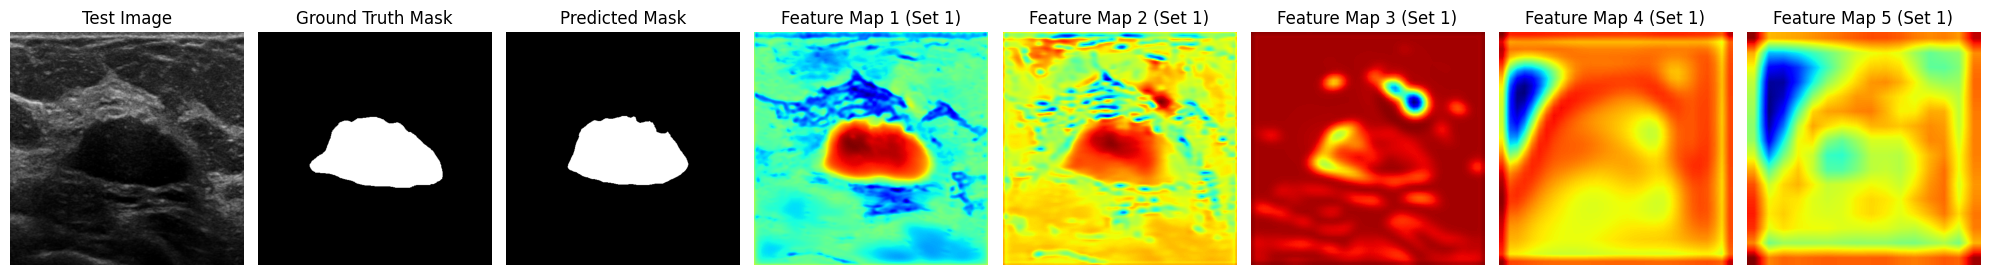

1/1 [==============================] - 0s 33ms/step


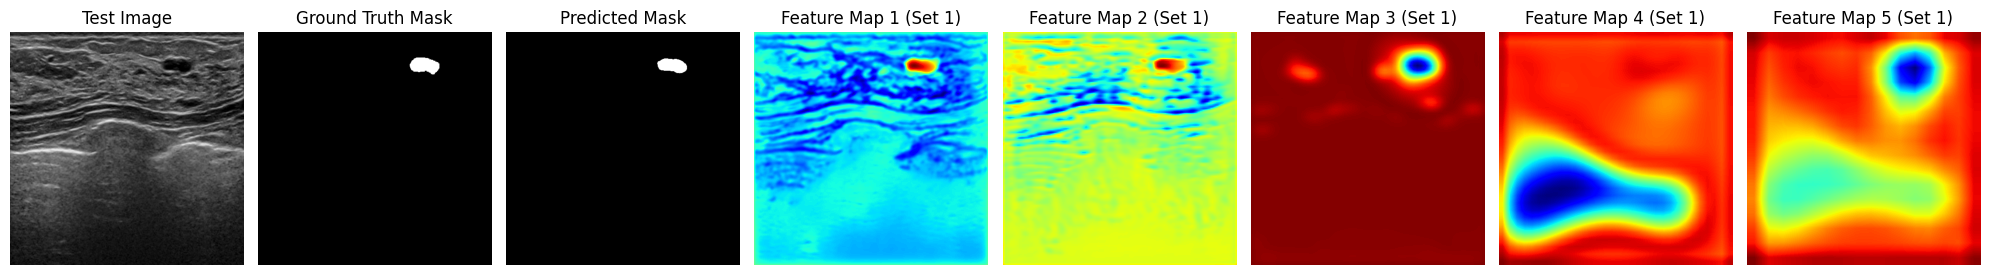

1/1 [==============================] - 0s 32ms/step


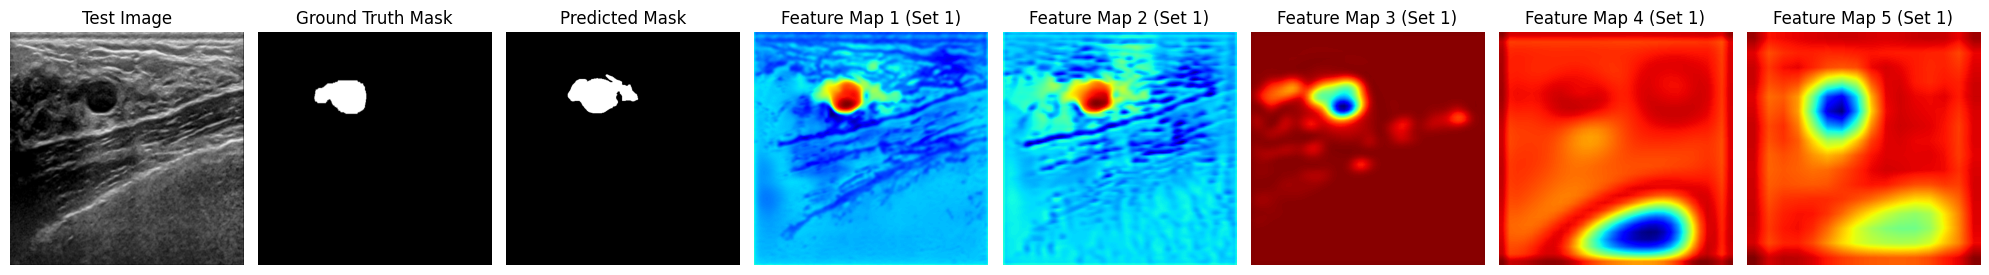

1/1 [==============================] - 0s 34ms/step


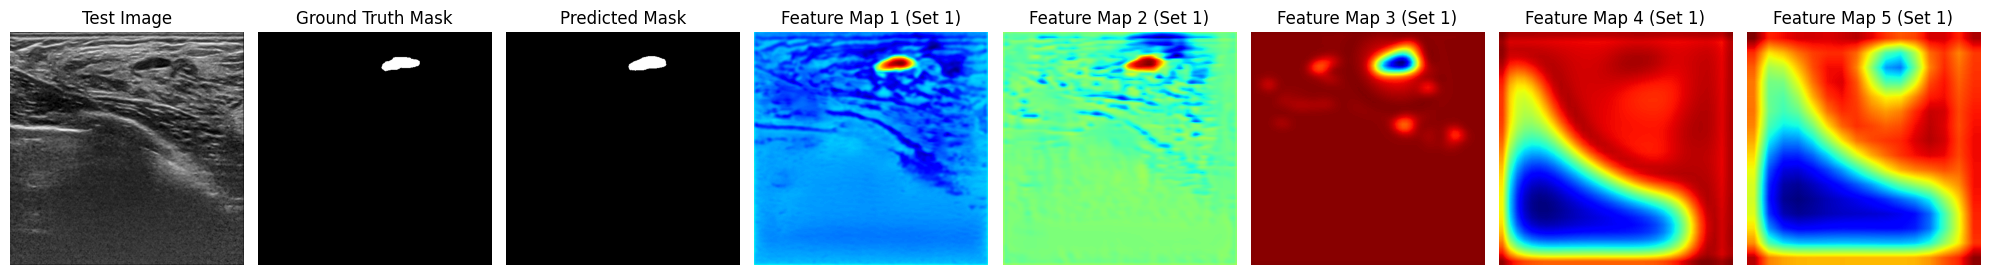

1/1 [==============================] - 0s 33ms/step


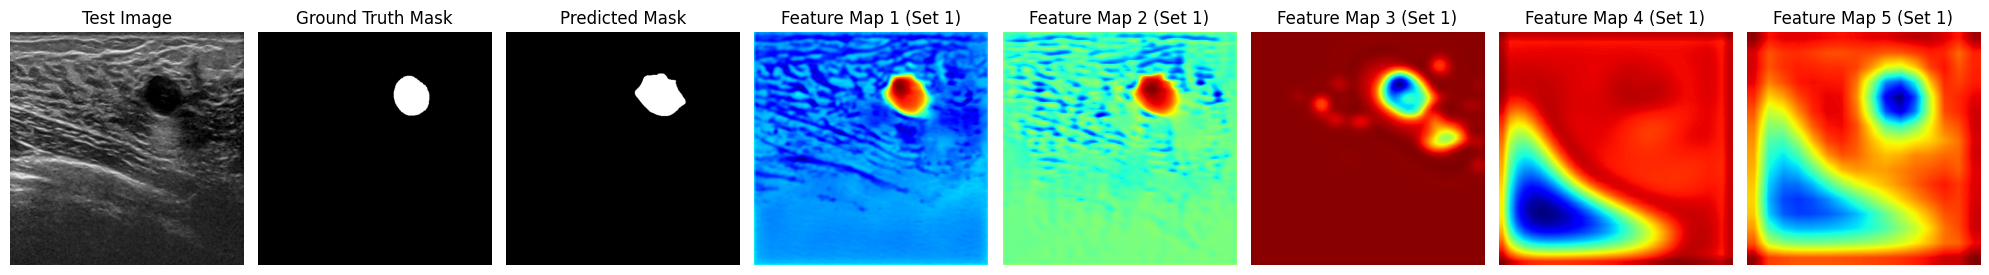

IndexError: index 17 is out of bounds for axis 0 with size 17

In [20]:
for w in range(40):
    # Load one image and corresponding mask from the test dataset
    test_image = X_test[w]  # Replace X_test with your actual test dataset
    test_mask = y_test[w]  # Replace y_test with your actual test masks

    # Reshape the image to match the input shape of the model
    test_image = np.reshape(test_image, (1,) + test_image.shape)

    # Predict the segmentation mask for the test image
    predicted_mask = model.predict(test_image)[0]
    feature_map1, feature_map2, feature_map3, feature_map4, feature_map5 = modeller.predict(test_image)

    # Convert the predicted mask values to binary (0 or 1)
    predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

    # Create subplots
    fig, axes = plt.subplots(1, 8, figsize=(20, 4))  # Adjusted the number of subplots

    # Plot the test image
    axes[0].imshow(test_image[0], cmap='gray')
    axes[0].set_title('Test Image')
    axes[0].axis('off')

    # Plot the ground truth mask
    axes[1].imshow(test_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Plot the predicted mask
    axes[2].imshow(predicted_mask_binary, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # Plot the feature maps (Set 1)
    for i in range(5):
        axes[i + 3].imshow(eval(f'feature_map{i + 1}')[0, :, :, 0], cmap='jet')
        axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
        axes[i + 3].axis('off')

    plt.tight_layout()
    plt.show()